In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

### Utils Plots

In [2]:
from scipy.stats import t, spearmanr, pearsonr
from sklearn.linear_model import LinearRegression


def fit_linear_regression(x, y):    
    model = LinearRegression()
    model.fit(x[:,None], y)
    
    x_fit = np.linspace(min(x), max(x), 100).reshape(-1, 1)
    y_fit = model.predict(x_fit)
    
    # Compute residuals and standard error
    y_pred = model.predict(x[:,None])
    residuals = y - y_pred
    dof = len(x) - 2
    residual_std = np.sqrt(np.sum(residuals ** 2) / dof)
    
    # Compute confidence interval
    t_value = t.ppf(1 - 0.025, dof)  # 95% CI
    mean_x = np.mean(x)
    n = len(x)
    
    se_fit = residual_std * np.sqrt(1/n + (x_fit - mean_x)**2 / np.sum((x - mean_x)**2))
    ci_upper = y_fit + t_value * se_fit[:,0]
    ci_lower = y_fit - t_value * se_fit[:,0]

    return x_fit, y_fit, ci_lower, ci_upper


def plot_correlation(x, y, xlabel=None, ylabel=None, ymin=None, ymax=None, yticks=None, ax=None, fontsize=13):    
    x_fit, y_fit, ci_lower, ci_upper = fit_linear_regression(x, y)

    if ax is None:
        ax = plt

    ax.scatter(x, y)
    ax.plot(x_fit, y_fit, color="blue")
    ax.fill_between(x_fit[:,0], ci_lower, ci_upper, alpha=0.2, color="blue")

    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize, usetex=True)
    
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize, usetex=True)

    if ymax is not None or ymin is not None:
        ax.set_ylim(ymin, ymax)

    if yticks is not None:
        ax.set_yticks(yticks)
    
    corr_spearman, p_spearman = spearmanr(x, y)
    corr_pearson, p_pearson = pearsonr(x, y)
    ax.set_title(
        r"$\rho_S=" + str(np.round(corr_spearman, 2))+"$" \
        # + r", $p_S=$" + str(np.round(p_spearman, 2)) \
        + r", $\rho_P=" + str(np.round(corr_pearson, 2))+"$"
        # + r", $p_P=$" + str(np.round(p_pearson, 2))
        , fontsize=fontsize,
        usetex=True
    )


In [3]:
def get_values_correlations(method, proj_id, indices, list_dataset_size, dataset, parent_dir):
    L = []
    L_otdd = []

    for idx in indices:
        dataset_size = list_dataset_size[idx]
        save_dir = f"{parent_dir}/{dataset}_seed_{idx}_size_{dataset_size}"
        
        dist = torch.load(f'{save_dir}/{method}_{proj_id}_dist.pt')[0,1]
        dist_otdd = torch.load(f'{save_dir}/otdd_dist.pt')[0,1]

        L.append(dist.item())
        L_otdd.append(dist_otdd.item())
    L = np.array(L)
    L_otdd = np.array(L_otdd)

    corr_spearman, p_spearman = spearmanr(L, L_otdd)
    corr_pearson, p_pearson = pearsonr(L, L_otdd)
    return corr_spearman, p_spearman, corr_pearson, p_pearson

In [4]:
def plot_correlations(projection_list, list_dataset_size, dataset, ymin, ymax, save=False):
    for proj_id in projection_list:
        L_sotdd = []
        L_otdd = []
        L_swb1dg = []
        L_swbg = []
    
        for idx in range(len(list_dataset_size)):
            dataset_size = list_dataset_size[idx]
            save_dir = f"{parent_dir}/{dataset}_seed_{idx}_size_{dataset_size}"
            
            dist_sotdd = torch.load(f'{save_dir}/sotdd_{proj_id}_dist.pt')[0,1]
            dist_otdd = torch.load(f'{save_dir}/otdd_dist.pt')[0,1]
            dist_swb1dg = torch.load(f'{save_dir}/swb1dg_{proj_id}_dist.pt')[0,1]
            try:
                dist_swbg = torch.load(f'{save_dir}/swbg_{proj_id}_dist.pt')[0,1]
            except: 
                dist_swbg = torch.tensor([0])
    
            L_sotdd.append(dist_sotdd.item())
            L_otdd.append(dist_otdd.item())
            L_swb1dg.append(dist_swb1dg.item())
            L_swbg.append(dist_swbg.item())
    
        fig, ax = plt.subplots(1, 3, figsize=(10,3))
        
        L_otdd, L_sotdd, L_swb1dg, L_swbg = np.array(L_otdd), np.array(L_sotdd), np.array(L_swb1dg), np.array(L_swbg)
        
        plot_correlation(L_sotdd * 100, L_otdd, r"SOTDD$\cdot10^2$ ("+str(proj_id)+" projs)", "OTDD", ax=ax[0], ymin=ymin, ymax=ymax, fontsize=15)
        plot_correlation(L_swb1dg * 100, L_otdd, r"SWB1DG$\cdot10^2$ ("+str(proj_id)+" projs)", ax=ax[1], ymin=ymin, ymax=ymax, yticks=[], fontsize=15)
        plot_correlation(L_swbg * 100, L_otdd, r"SWBG$\cdot10^2$ ("+str(proj_id)+" projs)", ax=ax[2], ymin=ymin, ymax=ymax, yticks=[], fontsize=15)

        if save:
            plt.savefig("./Figures/correlation_"+str(dataset)+"_"+str(proj_id)+"projs.pdf", format="pdf",
                        bbox_inches="tight")
        plt.show()


def bootstrap_correlations(rng, list_dataset_size, n_pairs=50, n_try=10):
    n_pairs = 50
    n_try = 10
    
    for proj_id in projection_list:
        L_corr_spearman_sotdd, L_corr_pearson_sotdd = [], []
        L_corr_spearman_swb1dg, L_corr_pearson_swb1dg = [], []
        L_corr_spearman_swbg, L_corr_pearson_swbg = [], []
    
        L_p_spearman_sotdd, L_p_pearson_sotdd = [], []
        L_p_spearman_swb1dg, L_p_pearson_swb1dg = [], []
        L_p_spearman_swbg, L_p_pearson_swbg = [], []
    
        for k in range(n_try):
            indices = rng.integers(0, len(list_dataset_size), size=n_pairs)
    
            corr_spearman_sotdd, p_spearman_sotdd, corr_pearson_sotdd, p_pearson_sotdd = get_values_correlations("sotdd",proj_id, indices, list_dataset_size, dataset, parent_dir)
            corr_spearman_swb1dg, p_spearman_swb1dg, corr_pearson_swb1dg, p_pearson_swb1dg = get_values_correlations("swb1dg", proj_id, indices, list_dataset_size, dataset, parent_dir)
    
            try:
                corr_spearman_swbg, p_spearman_swbg, corr_pearson_swbg, p_pearson_swbg = get_values_correlations("swbg", proj_id, indices, list_dataset_size, dataset, parent_dir)
            except:
                corr_spearman_swbg, p_spearman_swbg, corr_pearson_swbg, p_pearson_swbg = 0,0,0,0
    
            L_corr_spearman_sotdd.append(corr_spearman_sotdd)
            L_p_spearman_sotdd.append(p_spearman_sotdd)
            L_corr_pearson_sotdd.append(corr_pearson_sotdd)
            L_p_pearson_sotdd.append(p_pearson_sotdd)
    
            L_corr_spearman_swb1dg.append(corr_spearman_swb1dg)
            L_p_spearman_swb1dg.append(p_spearman_swb1dg)
            L_corr_pearson_swb1dg.append(corr_pearson_swb1dg)
            L_p_pearson_swb1dg.append(p_pearson_swb1dg)
    
            L_corr_spearman_swbg.append(corr_spearman_swbg)
            L_p_spearman_swbg.append(p_spearman_swbg)
            L_corr_pearson_swbg.append(corr_pearson_swbg)
            L_p_pearson_swbg.append(p_pearson_swbg)
    
        print("projs="+str(proj_id))
        print("Spearman correlation SOTDD", np.mean(L_corr_spearman_sotdd), np.std(L_corr_spearman_sotdd))
        print("Spearman correlation SWB1DG", np.mean(L_corr_spearman_swb1dg), np.std(L_corr_spearman_swb1dg))
        print("Spearman correlation SWBG", np.mean(L_corr_spearman_swbg), np.std(L_corr_spearman_swbg))
    
        print("Spearman p-value SOTDD", np.mean(L_p_spearman_sotdd), np.std(L_p_spearman_sotdd))
        print("Spearman p-value SWB1DG", np.mean(L_p_spearman_swb1dg), np.std(L_p_spearman_swb1dg))
        print("Spearman p-value SWBG", np.mean(L_p_spearman_swbg), np.std(L_p_spearman_swbg))
    
        print("Pearson correlation SOTDD", np.mean(L_corr_pearson_sotdd), np.std(L_corr_pearson_sotdd))
        print("Pearson correlation SWB1DG", np.mean(L_corr_pearson_swb1dg), np.std(L_corr_pearson_swb1dg))
        print("Pearson correlation SWBG", np.mean(L_corr_pearson_swbg), np.std(L_corr_pearson_swbg))
    
        print("Pearson p-value SOTDD", np.mean(L_p_pearson_sotdd), np.std(L_p_pearson_sotdd))
        print("Pearson p-value SWB1DG", np.mean(L_p_pearson_swb1dg), np.std(L_p_pearson_swb1dg))
        print("Pearson p-value SWBG", np.mean(L_p_pearson_swbg), np.std(L_p_pearson_swbg))
    
        print()

### Results MNIST

In [5]:
seed = 42
rng = np.random.default_rng(seed)
list_dataset_size = rng.integers(low=5, high=11, size=200) * 1000
projection_list = [10, 50, 100, 500, 1000, 5000 , 10000]
dataset = "MNIST"
parent_dir = f'./results_corr_{dataset}_200'

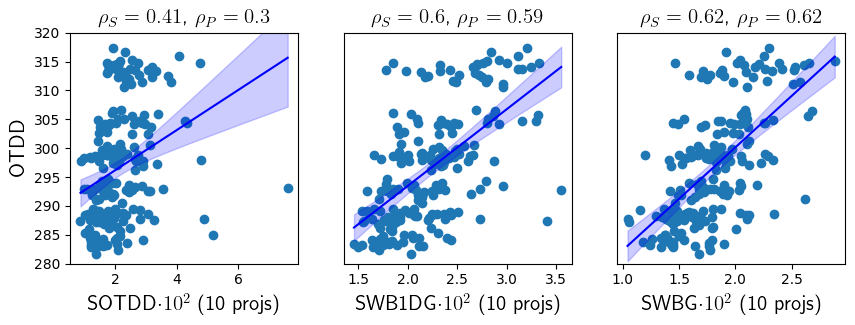

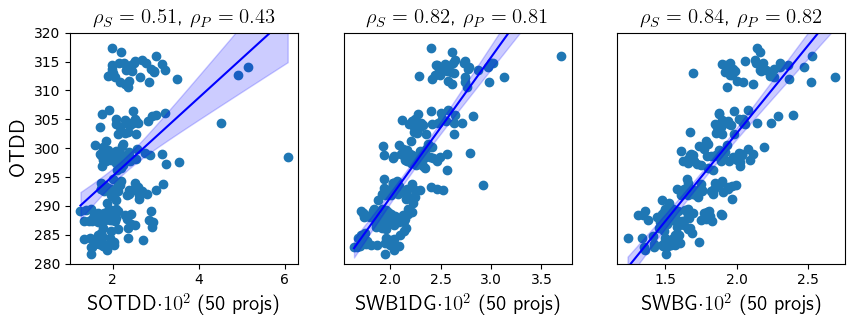

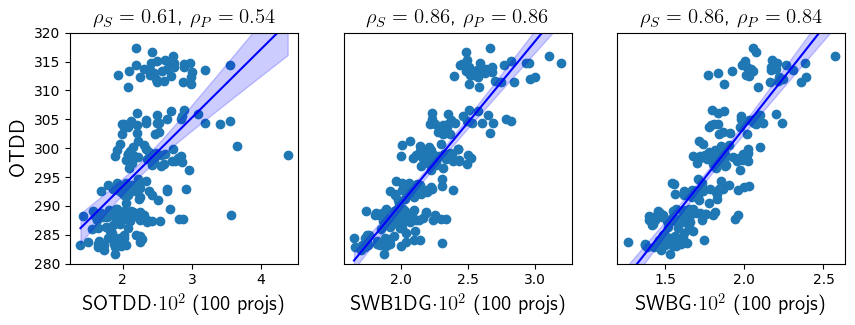

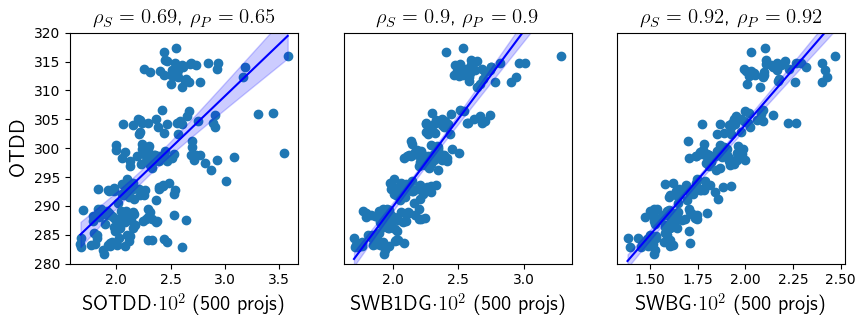

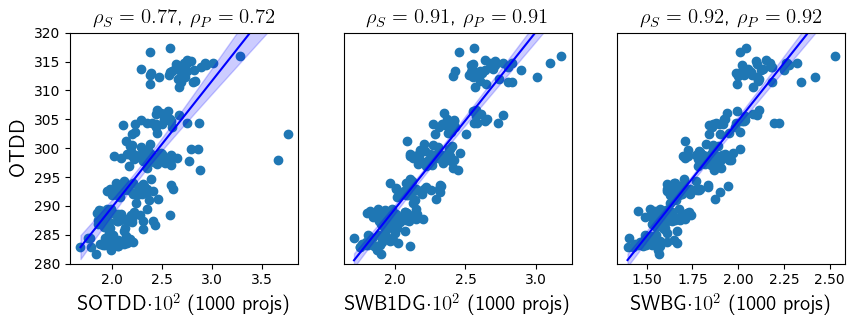

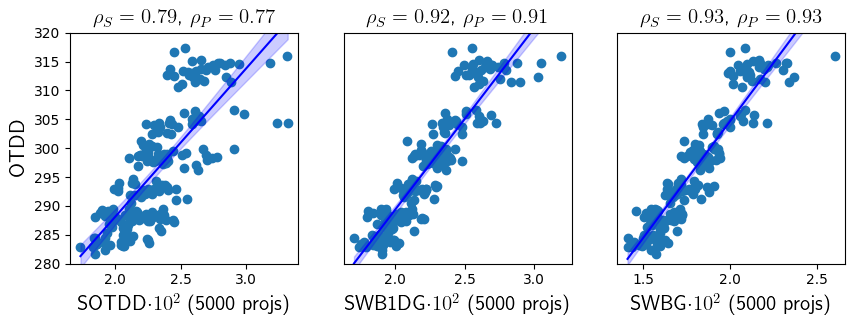

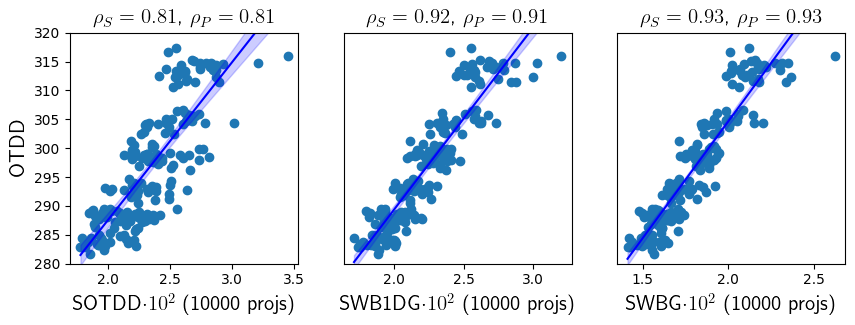

In [6]:
plot_correlations(projection_list, list_dataset_size, dataset, ymin=280, ymax=320, save=True)

In [7]:
bootstrap_correlations(rng, list_dataset_size, n_pairs=50, n_try=10)

projs=10
Spearman correlation SOTDD 0.4436822814615514 0.0642974741968332
Spearman correlation SWB1DG 0.5780061680062494 0.11322954630498916
Spearman correlation SWBG 0.6151465152316 0.10376851184215762
Spearman p-value SOTDD 0.0041343102546897905 0.006390207936578947
Spearman p-value SWB1DG 0.001238328898463812 0.0024259378238900274
Spearman p-value SWBG 0.0003802402763990908 0.001069708178047433
Pearson correlation SOTDD 0.3617829053119495 0.12158164561752044
Pearson correlation SWB1DG 0.6017475231427116 0.12198270916556755
Pearson correlation SWBG 0.613085449381362 0.13141928682537976
Pearson p-value SOTDD 0.07069230009583154 0.13922481221851302
Pearson p-value SWB1DG 0.0010127855461803136 0.001980671227496636
Pearson p-value SWBG 0.004049745462956611 0.01211739615222583

projs=50
Spearman correlation SOTDD 0.42523548470671696 0.08917229298589303
Spearman correlation SWB1DG 0.8159495280161198 0.045321712044086
Spearman correlation SWBG 0.8344454208739011 0.024089654316969935
Spearma

### Results CIFAR10

In [8]:
seed = 42
rng = np.random.default_rng(seed)
list_dataset_size = rng.integers(low=5, high=11, size=200) * 1000
projection_list = [10, 50, 100, 500, 1000, 5000, 10000]
dataset = "CIFAR10"
parent_dir = f'./results_corr_{dataset}_200'

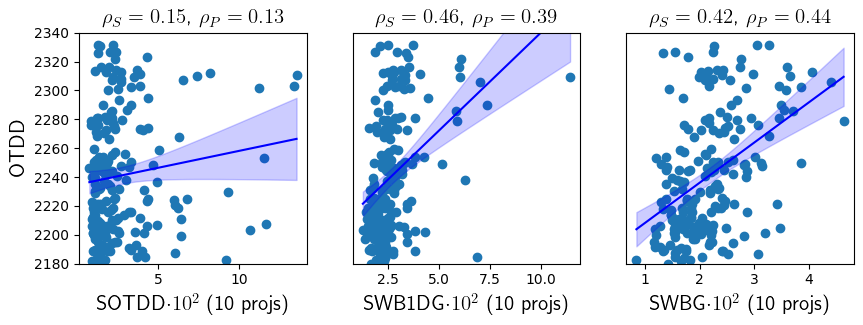

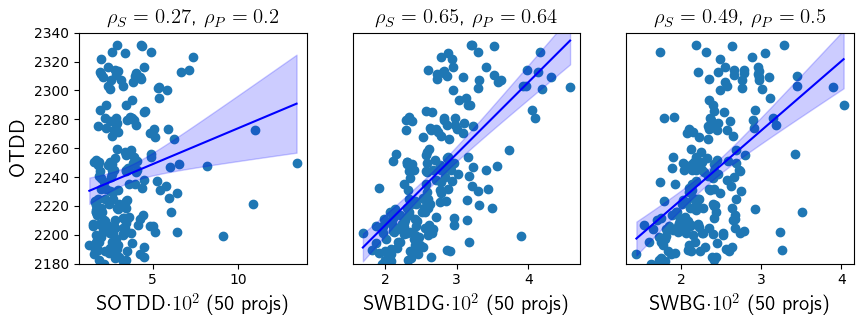

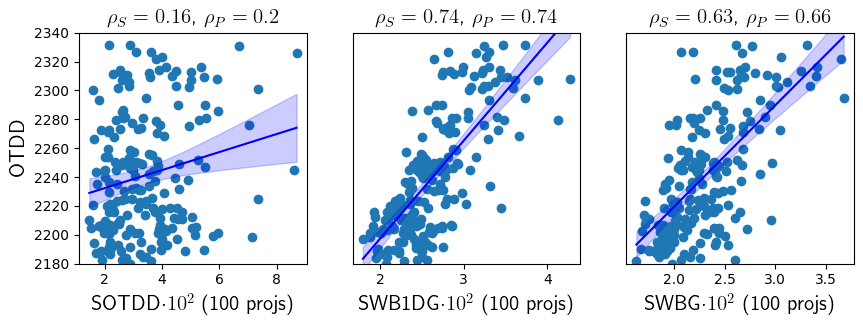

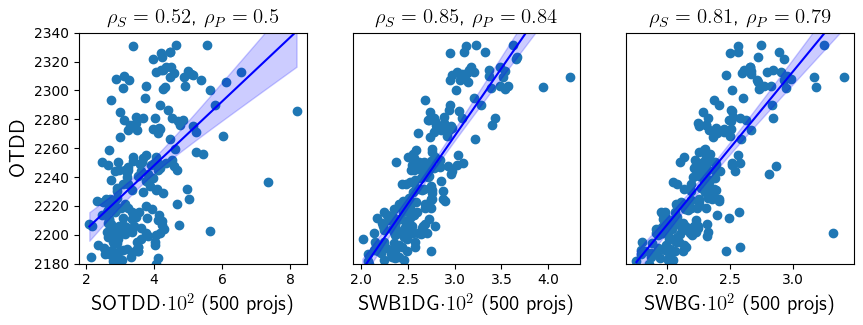

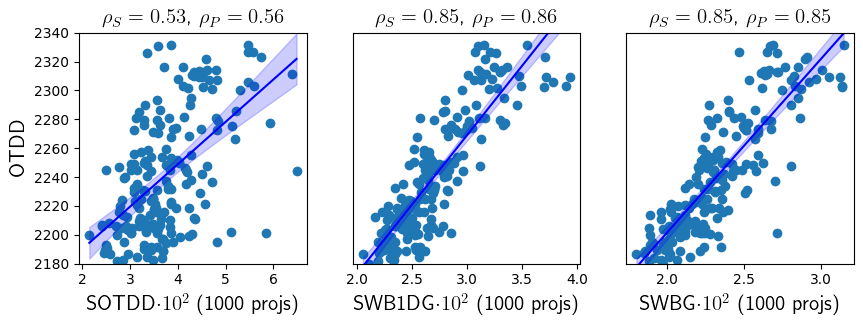

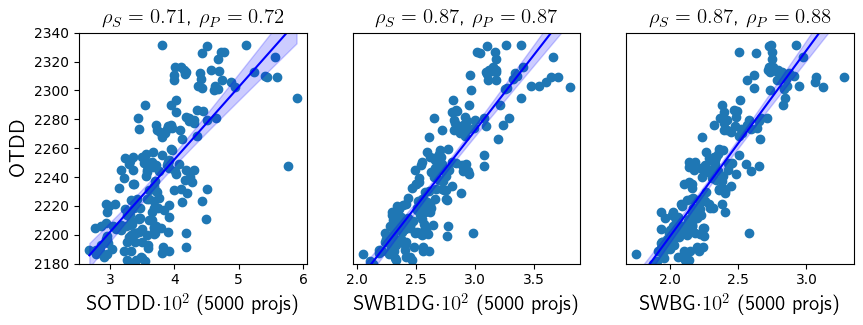

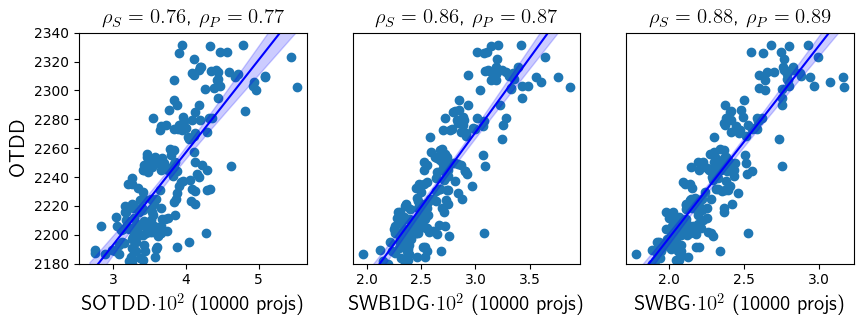

In [9]:
plot_correlations(projection_list, list_dataset_size, dataset, ymin=2180, ymax=2340, save=True)

In [10]:
bootstrap_correlations(rng, list_dataset_size, n_pairs=50, n_try=10)

projs=10
Spearman correlation SOTDD 0.1398232179907001 0.11261791177763084
Spearman correlation SWB1DG 0.44320773089514576 0.10780389164804023
Spearman correlation SWBG 0.4024748465241917 0.12247083695598646
Spearman p-value SOTDD 0.43712460325961233 0.35843683945242144
Spearman p-value SWB1DG 0.007660826888835688 0.010018017266771371
Spearman p-value SWBG 0.054696785107358835 0.15034348146353532
Pearson correlation SOTDD 0.15969470576179615 0.09304596960487244
Pearson correlation SWB1DG 0.38634894329228964 0.1459378894201099
Pearson correlation SWBG 0.42683249867427503 0.09543237035699922
Pearson p-value SOTDD 0.3538210131960465 0.3106314373471714
Pearson p-value SWB1DG 0.08411384101000628 0.21514787034961882
Pearson p-value SWBG 0.015225684810478571 0.035524992602683575

projs=50
Spearman correlation SOTDD 0.305545408908007 0.12900581180615653
Spearman correlation SWB1DG 0.6259555542294472 0.06442713353823017
Spearman correlation SWBG 0.40440203008611386 0.09751795387231071
Spearman 